# Introducing Word Embeddings

In this exercise, we would train word embeddings using a state-of-the-art embeddings library fastText. The first step of the exercise is to install the fasttext library. Proceed with the following steps:

## FastText installation

> pip install fasttext

If you are having problems, try this command:
> sudo apt-get install g++

## Generate Embeddings

In [1]:
import fasttext
import numpy as np

In [2]:
model = fasttext.train_unsupervised('epfldocs.txt', model = 'cbow')
vocabulary = model.words
word_embeddings = np.array([model[word] for word in vocabulary])

Read 0M words
Number of words:  432
Number of labels: 0
Progress: 100.0% words/sec/thread:   87726 lr:  0.000000 avg.loss:  3.393834 ETA:   0h 0m 0s


## Use Pretrained Embeddings
If you are unable to install fasttext, you can use the preembeddings we provide.

In [3]:
import sys
import codecs
import numpy as np

# Edit this, or just move model_epfldocs.vec to the directory where this notebook is situated
if False:
    directory_path = './'

    def load_embeddings(file_name):
        with codecs.open(file_name, 'r', 'utf-8') as f_in:
            lines = f_in.readlines()
            lines = lines[1:]
            vocabulary, wv = zip(*[line.strip().split(' ', 1) for line in lines])
        wv = np.loadtxt(wv)
        return wv, vocabulary


    # Replace the path based on your own machine.
    word_embeddings, vocabulary = load_embeddings(directory_path + 'model_epfldocs.vec')




## Visualize Embeddings

In the third phase of this exercise, we will visualize the generated embeddings using t-SNE (T-Distributed Stochastic Neighbouring Entities). t-SNE is a dimensionality reduction algorithm which is well suited for such visualization tasks.


In [4]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import logging

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, init = 'pca') 
vis_data = tsne.fit_transform(word_embeddings)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 432 samples in 0.000s...
[t-SNE] Computed neighbors for 432 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 432 / 432
[t-SNE] Mean sigma: 0.069611
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.166943
[t-SNE] KL divergence after 1000 iterations: 0.116363


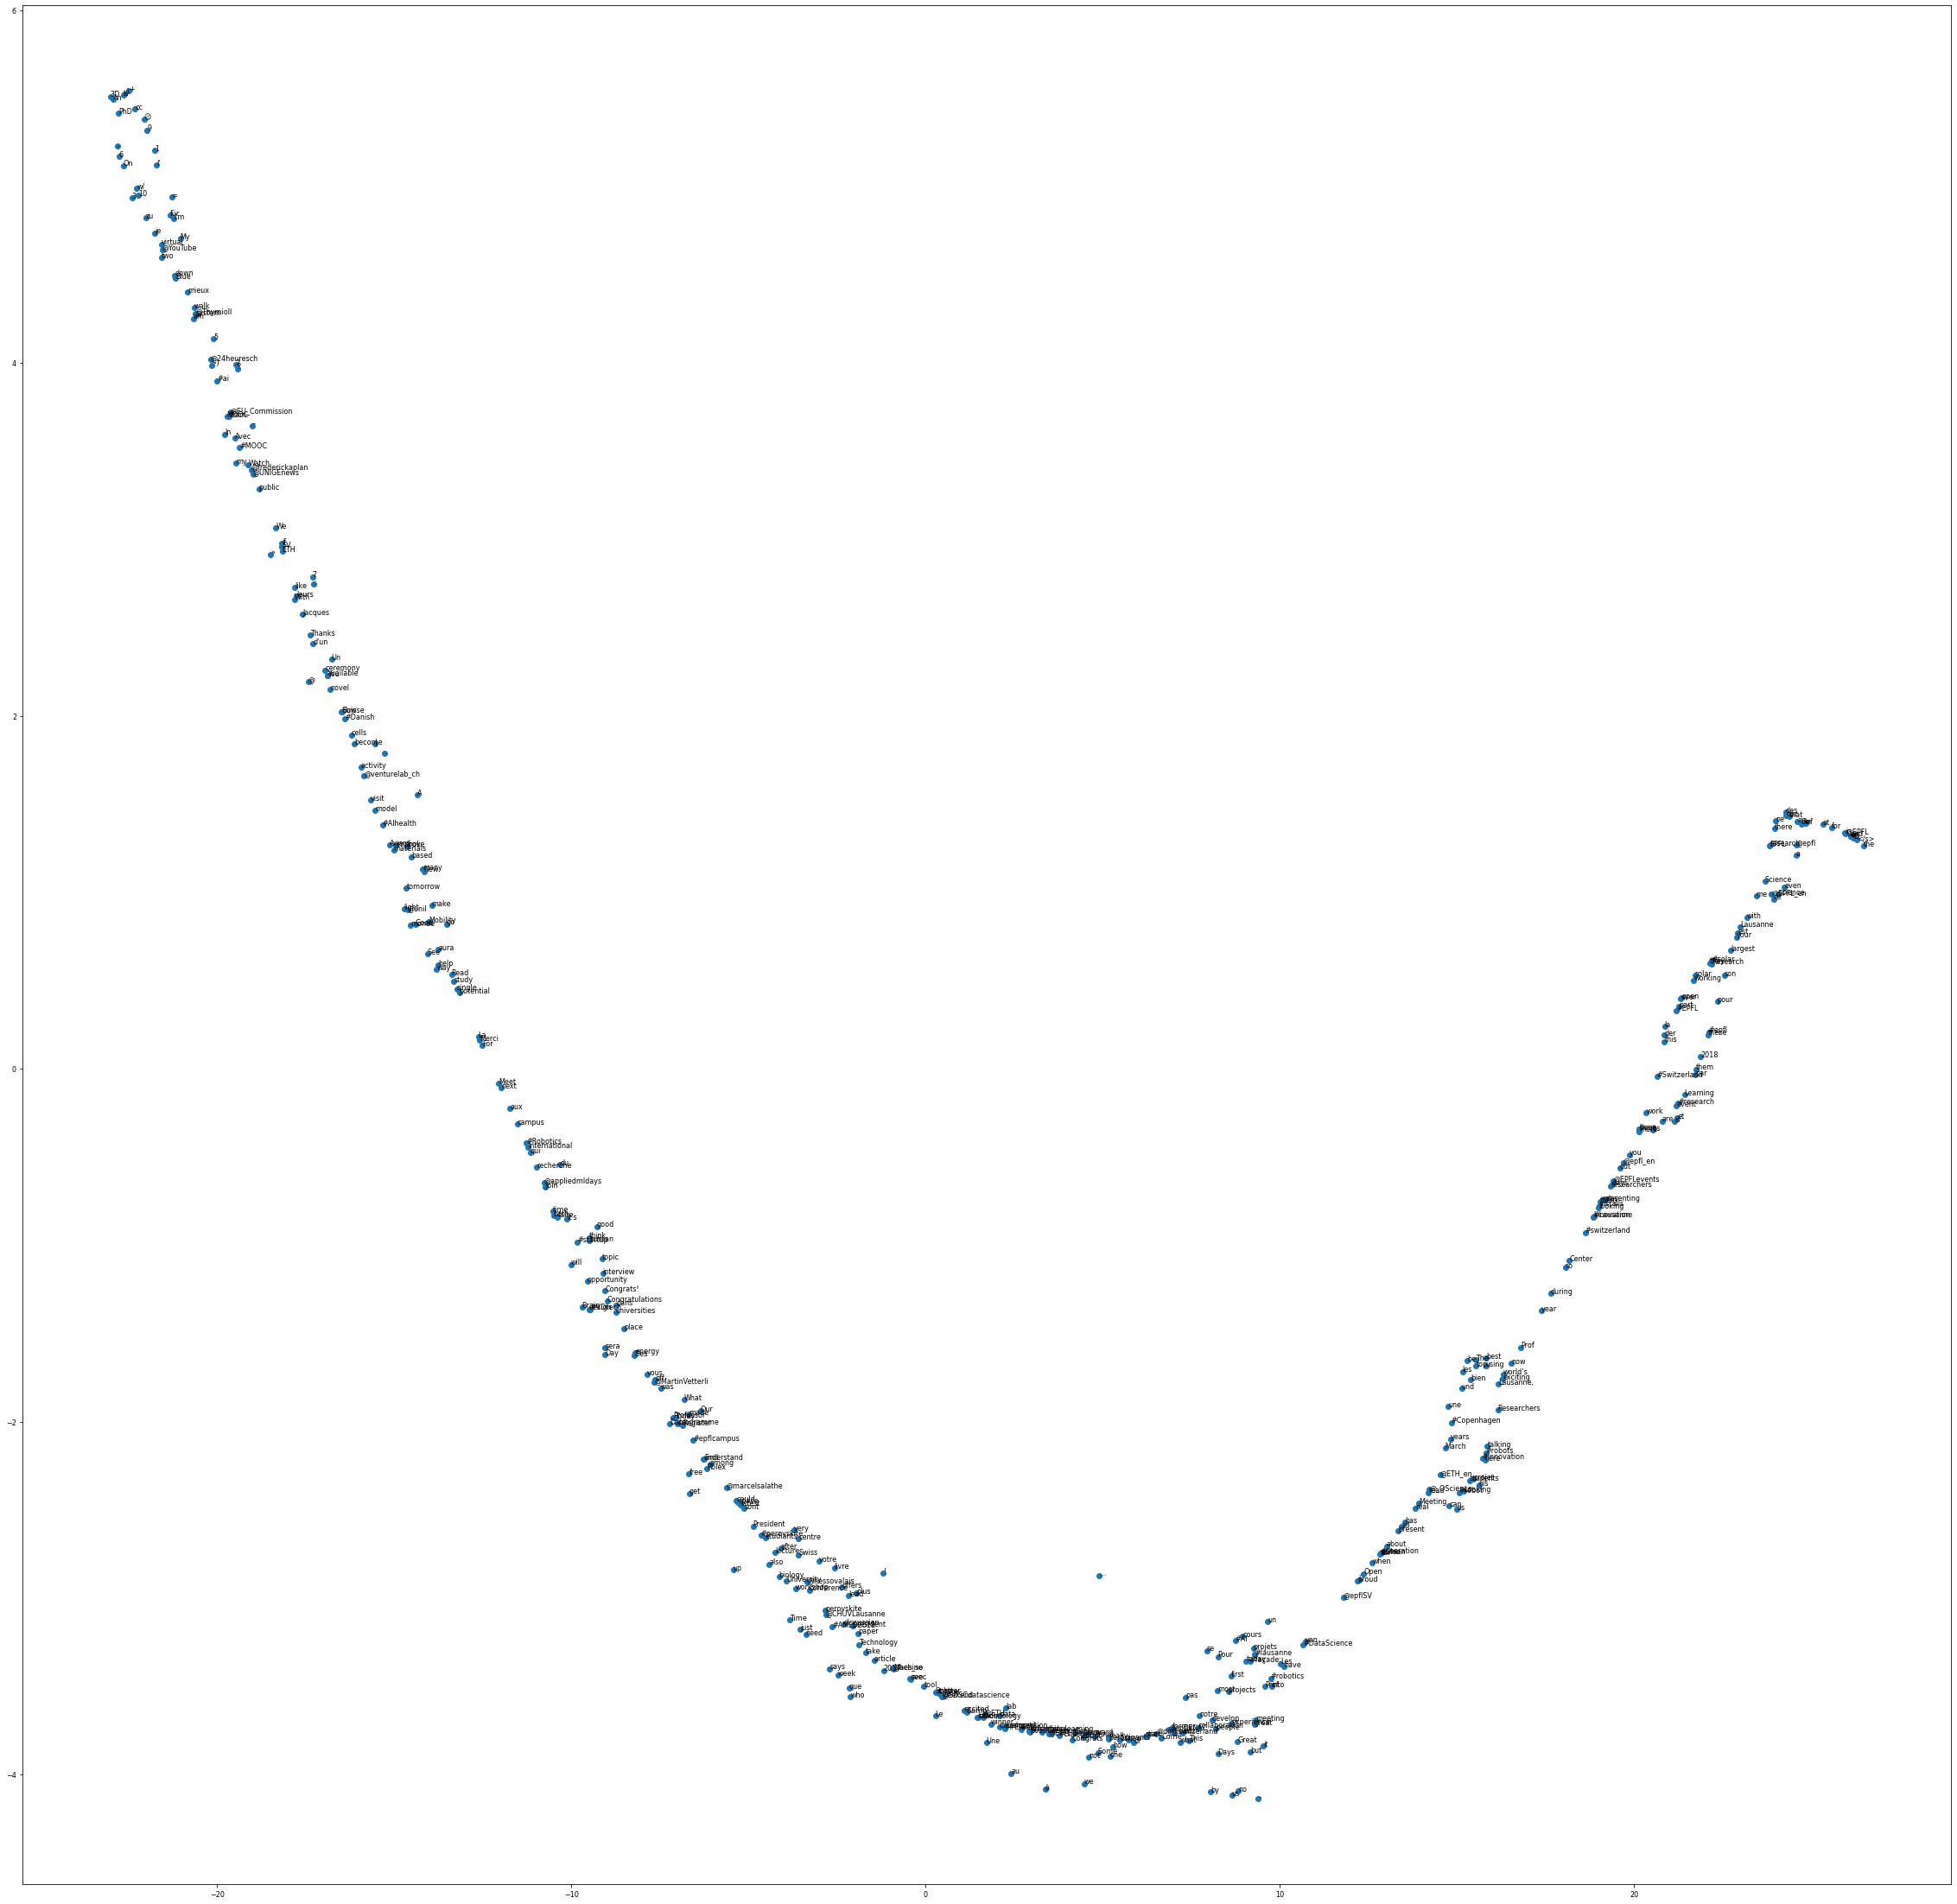

In [5]:
vis_data_x = vis_data[:,0]
vis_data_y = vis_data[:,1]

plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(40, 40)) 
plt.scatter(vis_data_x, vis_data_y)

for label, x, y in zip(vocabulary, vis_data_x, vis_data_y):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

## Question

Observe the plot of word embeddings. Do you observe any patterns?



## Question

Write a python function to find the most similar terms for a given term. The similarity between two terms is defined as the cosine similarity between their corresponding word embeddings.

Find the top 5 terms that are most similar to 'la', 'EPFL', '#robot', 'this', 

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

def find_most_similar(input_term, word_embeddings, vocabulary, num_terms=5):
    input_index = None
    for i, term in enumerate(vocabulary):
        if term == input_term:
            input_index = i
            break
        
    cos_sim = cosine_similarity(word_embeddings)
    lst = [x[1] for x in sorted(zip(cos_sim[i], vocabulary), key=lambda x: x[0], reverse=True)[:num_terms]]

    return lst
    
ans1 = find_most_similar('EPFL', word_embeddings, vocabulary, num_terms=5)
ans2 = find_most_similar('la', word_embeddings, vocabulary, num_terms=5)
ans3 = find_most_similar('#robot', word_embeddings, vocabulary, num_terms=5)
ans4 = find_most_similar('this', word_embeddings, vocabulary, num_terms=5)

print(ans1)
print(ans2)
print(ans3)
print(ans4)

['EPFL', '@EPFL', '#EPFL', '@EPFLevents', '@EPFL_en']
['la', '@venturelab_ch', '@EPFL', 'Lausanne', '@EPFLevents']
['#robot', '#robots', '#robotics', 'robot', 'presenting']
['this', '@EPFLevents', 'presenting', '@EPFL_en', 'the']


## Question [Optional]
​
Observe the word embeddings that are visualized in this link http://www.anthonygarvan.com/wordgalaxy/ . Can you make some interesting observations? 

# Basic Search Engine Using Word Embeddings



In this exercise, we would put our word embeddings to test by using them for information retrieval. 
The idea is that, the documents that have the most similar embedding vectors to the one belongs to query should rank higher.
The documents may not necessarily include the keywords in the query.



In [7]:
# Loading of libraries and documents
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
import math
from collections import Counter

# Read a list of documents from a file. Each line in a file is a document
with open("epfldocs.txt", ) as f:
    content = f.readlines()
        
original_documents = [x.strip() for x in content] 

## Question
Since both the documents and the query is of variable size, we should aggregate the vectors of the words in the query by some strategy. This could be taking the minimum vector, maximum vector or the mean. Fill in the code below.

In [8]:
# Create a dictionary of vectors for easier search
vector_dict = dict(zip(vocabulary, word_embeddings))

def aggregate_vector_list(vlist, aggfunc):
    if aggfunc == 'max':
        return np.array(vlist).max(axis=0)
    elif aggfunc == 'min':
        return np.array(vlist).min(axis=0)
    elif aggfunc == 'mean':
        return np.array(vlist).mean(axis=0)
    else:
        return np.zeros(np.array(vlist).shape[1])

possible_aggfuncs = ["max", "min", "mean"]

aggregated_doc_vectors = {}


# Aggregate vectors of documents beforehand

for aggfunc in possible_aggfuncs:
    aggregated_doc_vectors[aggfunc] = np.zeros((len(original_documents), word_embeddings.shape[1]))
    for index, doc in enumerate(original_documents):
        
        vlist = [vector_dict[token] for token in fasttext.tokenize(doc) if token in vector_dict]
        if(len(vlist) < 1):
            continue 
        else:
            aggregated_doc_vectors[aggfunc][index] = aggregate_vector_list(vlist, aggfunc) 

## Question
Aggregate the query and find the most similar documents using cosine distance between the query's vector and document's aggregated vector. Are they seem to relevant?

In [38]:
from sklearn.metrics.pairwise import cosine_similarity

query = "EPFL"
def aggregate_query(query, aggfunc):
    # TODO
    lst_lst = []
    token_list = fasttext.tokenize(query)
    if len(token_list) == 1:
        return vector_dict[token_list[0]]
    else:
        for token in token_list:
            if token in vector_dict:
                lst_lst.append(vector_dict[token])

        # this means that there is no words in the query that is included in the vocabulary
        if not lst_lst:
            raise Exception("No words in the query that is included in the vocabulary")
        else:
            query_vector = aggregate_vector_list(lst_lst, aggfunc)
            return query_vector
        # Raise an error message for the case when there is no words in the query that is included in the vocabulary
    # This should return a vector of shape (1, word_embeddings.shape[1])
    
def get_most_similar_documents(query_vector, aggfunc, k = 5):
    query_vector = query_vector.reshape(1, -1)
    # Calculate the similarity with each vector. 
    # Hint: Cosine similarity function takes a matrix as input so you do not need to loop through each document vector.
    sim = cosine_similarity(query_vector, aggregated_doc_vectors[aggfunc])
    
    # Rank the document vectors according to their cosine similarity with 
    indexes = np.argsort(sim, axis=-1, kind='quicksort', order=None) # This is sorted in ascending order
    indexes = indexes[0]
    indexes = indexes[::-1] # Convert to descending
    return indexes


def search_vec_embeddings(query, topk = 10, aggfunc = 'mean'):
    query_vector = aggregate_query(query, aggfunc)
    indexes = get_most_similar_documents(query_vector, aggfunc)
    # Print the top k documents
    indexes = indexes[0:topk]
    for index in indexes:
        print(original_documents[index])

In [39]:

search_vec_embeddings('EPFL', aggfunc = 'mean')

EPFL morning #epfl #lausanne #photography https://t.co/6IXddicblu
Die Onlineschule der @EPFL hat mit dem «Certificate of Open Studies» einen neuen akademischen Diplomtypus ins Leben gerufen | EPFL https://t.co/WzVUFMYxID #Weiterbildung #Diplom #COS
EPFL is joining the Global Entrepreneurship Week next Tuesday! Learn more and join us https://t.co/Piz1hi72jt  #GEWCH2017 #VDtech @EPFL_en https://t.co/Wejk5IWILc
Sunrise over the #RolexLearningCenter #EPFL #thingofbeauty #nature #winter #Lausanne @EPFL @EPFL_en @MyLausanne #Switzerland @MySwitzerland_e https://t.co/T2OkBgYqsz
Congratulations EPFL Life Sciences Master students from your SV teachers (@befcorreia,Hantschel,@MBlokesch) @EPFL_en @epflSV #Magistrale2017 https://t.co/0giVobWPuo
Always something happening at and around EPFL 😎 https://t.co/fc9t0GBUhX
About p-value reliability @EPFL #openscience #oset2017 https://t.co/4SvpDoEDyH
Graphene-Based Nanotube Biosensor Could Detect Single Biomolecules Efficiently https://t.co/biwGqtdUFw @AU

## Question
Compare the results with the vector space retrieval.


In [40]:
# VECTOR SPACE RETRIEVAL (From Exercise 1)
# Retrieval oracle 
from operator import itemgetter
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 1, stop_words = 'english')
features = tf.fit_transform(original_documents)
npm_tfidf = features.todense()

# Return all document ids that that have cosine similarity with the query larger than a threshold
def search_vec_sklearn(query, topk = 10, features = features, threshold=0.1):
    new_features = tf.transform([query])
    cosine_similarities = cosine_similarity(new_features, features).flatten()
    related_docs_indices, cos_sim_sorted = zip(*sorted(enumerate(cosine_similarities), key=itemgetter(1), 
                                                       reverse=True))
    doc_ids = []
    for i, cos_sim in enumerate(cos_sim_sorted):
        if cos_sim < threshold or i >= topk:
            break
        doc_ids.append(related_docs_indices[i])
    
    for index in doc_ids:
        print(original_documents[index])

In [41]:
search_vec_embeddings('EPFL', aggfunc = 'mean')
print("---------------------------------")
search_vec_sklearn("EPFL")

EPFL morning #epfl #lausanne #photography https://t.co/6IXddicblu
Die Onlineschule der @EPFL hat mit dem «Certificate of Open Studies» einen neuen akademischen Diplomtypus ins Leben gerufen | EPFL https://t.co/WzVUFMYxID #Weiterbildung #Diplom #COS
EPFL is joining the Global Entrepreneurship Week next Tuesday! Learn more and join us https://t.co/Piz1hi72jt  #GEWCH2017 #VDtech @EPFL_en https://t.co/Wejk5IWILc
Sunrise over the #RolexLearningCenter #EPFL #thingofbeauty #nature #winter #Lausanne @EPFL @EPFL_en @MyLausanne #Switzerland @MySwitzerland_e https://t.co/T2OkBgYqsz
Congratulations EPFL Life Sciences Master students from your SV teachers (@befcorreia,Hantschel,@MBlokesch) @EPFL_en @epflSV #Magistrale2017 https://t.co/0giVobWPuo
Always something happening at and around EPFL 😎 https://t.co/fc9t0GBUhX
About p-value reliability @EPFL #openscience #oset2017 https://t.co/4SvpDoEDyH
Graphene-Based Nanotube Biosensor Could Detect Single Biomolecules Efficiently https://t.co/biwGqtdUFw @AU

## Question
You will realize that not all the words in your queries are in the vocabulary, so your queries fail to retrieve any documents. Think of possible solutions to overcome this problem.